<a href="https://colab.research.google.com/github/avahuu/dc_bikesharing/blob/main/bikesharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from pathlib import Path

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Latex, Markdown

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Data Preparation
#Modify holiday, weekday, workingday, and weathersit here.
bike = pd.read_csv('/content/drive/MyDrive/github/bicycle/bikeshare.txt')

bike['holiday'] = bike['holiday'].replace({0: 'no', 1: 'yes'})

bike['weekday'] = bike['weekday'].replace({
    0: 'Sun',
    1: 'Mon',
    2: 'Tue',
    3: 'Wed',
    4: 'Thu',
    5: 'Fri',
    6: 'Sat'
})

bike['workingday'] = bike['workingday'].replace({0: 'no', 1: 'yes'})

bike['weathersit'] = bike['weathersit'].replace({
    1: 'Clear',
    2: 'Mist',
    3: 'Light',
    4: 'Heavy'
})

bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,0,1,1


In [27]:
daily_counts = (
    bike.groupby('dteday')[['casual', 'registered']].sum()
    .join(bike[['dteday', 'workingday']].drop_duplicates().set_index('dteday'))
)

daily_counts.head()

,casual,registered,workingday
dteday,,,
2011-01-01,331,654,no
2011-01-02,131,670,no
2011-01-03,120,1229,yes
2011-01-04,108,1454,yes
2011-01-05,82,1518,yes


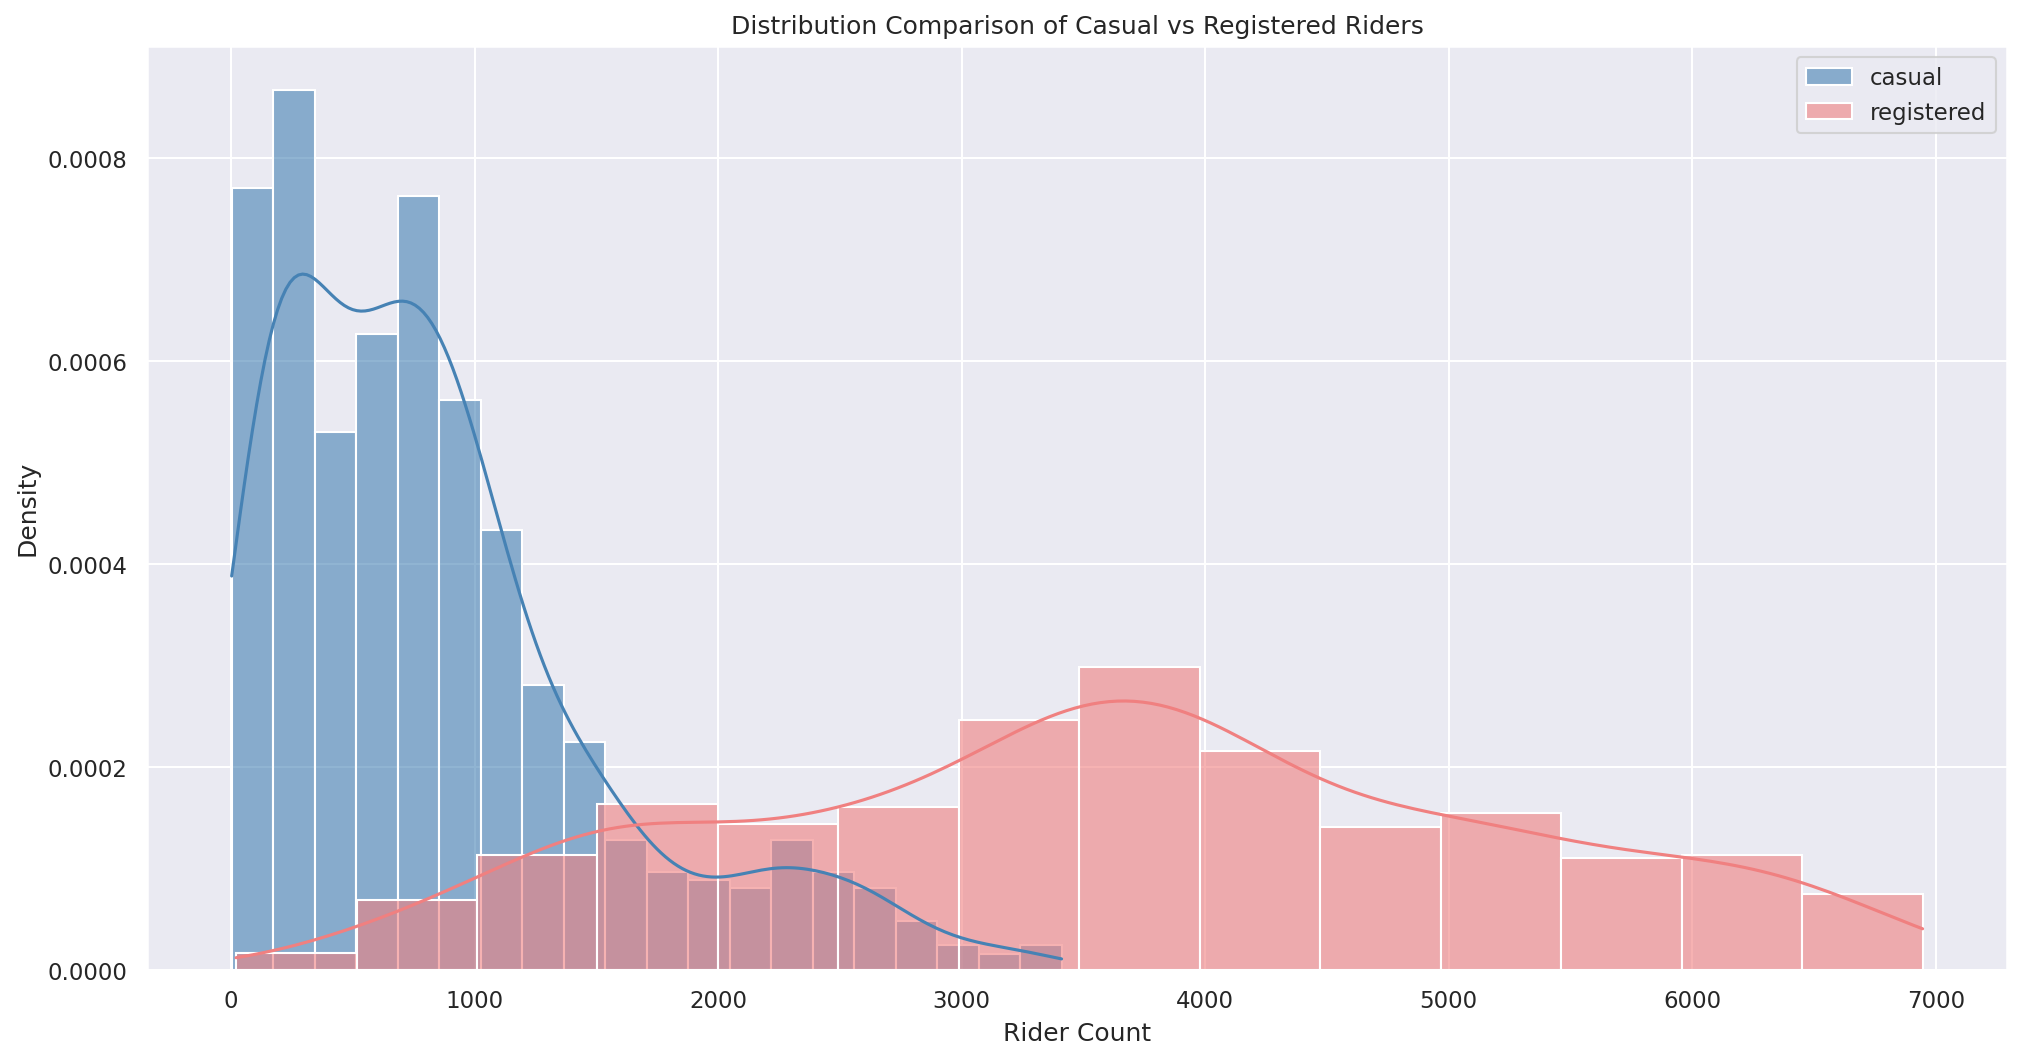

In [9]:
# Matplotlib
sns.histplot(data=daily_counts, x='casual', color='steelblue', label='casual',
             stat='density', kde=True, alpha=0.6)
sns.histplot(data=daily_counts, x='registered', color='lightcoral', label='registered',
             stat='density', kde=True, alpha=0.6)

# Labels and title
plt.xlabel('Rider Count')
plt.ylabel('Density')
plt.title('Distribution Comparison of Casual vs Registered Riders')
plt.legend()
plt.show()

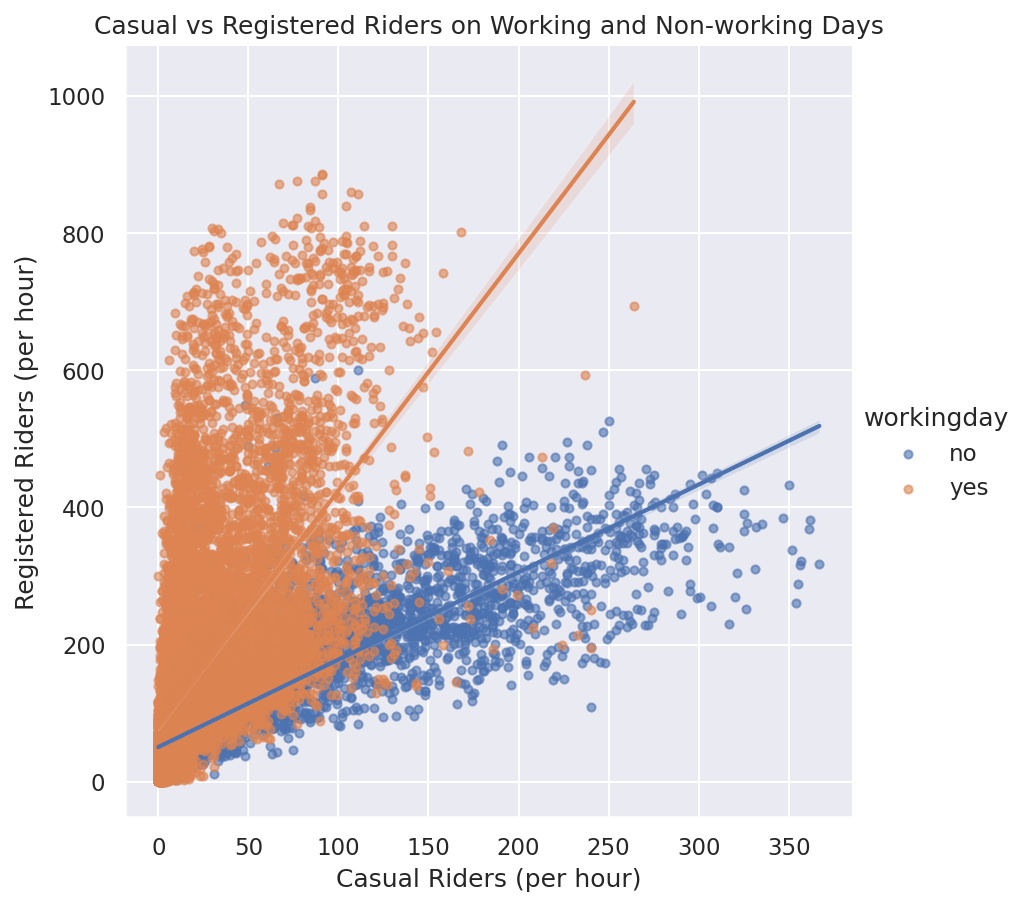

In [10]:
# Investigate relationship between casual and registered counts

sns.set(font_scale=1) # This line automatically makes the font size a bit bigger on the plot. You do not need to change this line
sns.lmplot(
    data=bike,
    x='casual',
    y='registered',
    hue='workingday',        # color by working day
    height=6,                # control figure size
    scatter_kws={'s': 15, 'alpha': 0.6},  # make points small and semi-transparent
    line_kws={'lw': 2},      # thinner regression line
)

plt.title('Casual vs Registered Riders on Working and Non-working Days')
plt.xlabel('Casual Riders (per hour)')
plt.ylabel('Registered Riders (per hour)')
plt.show()

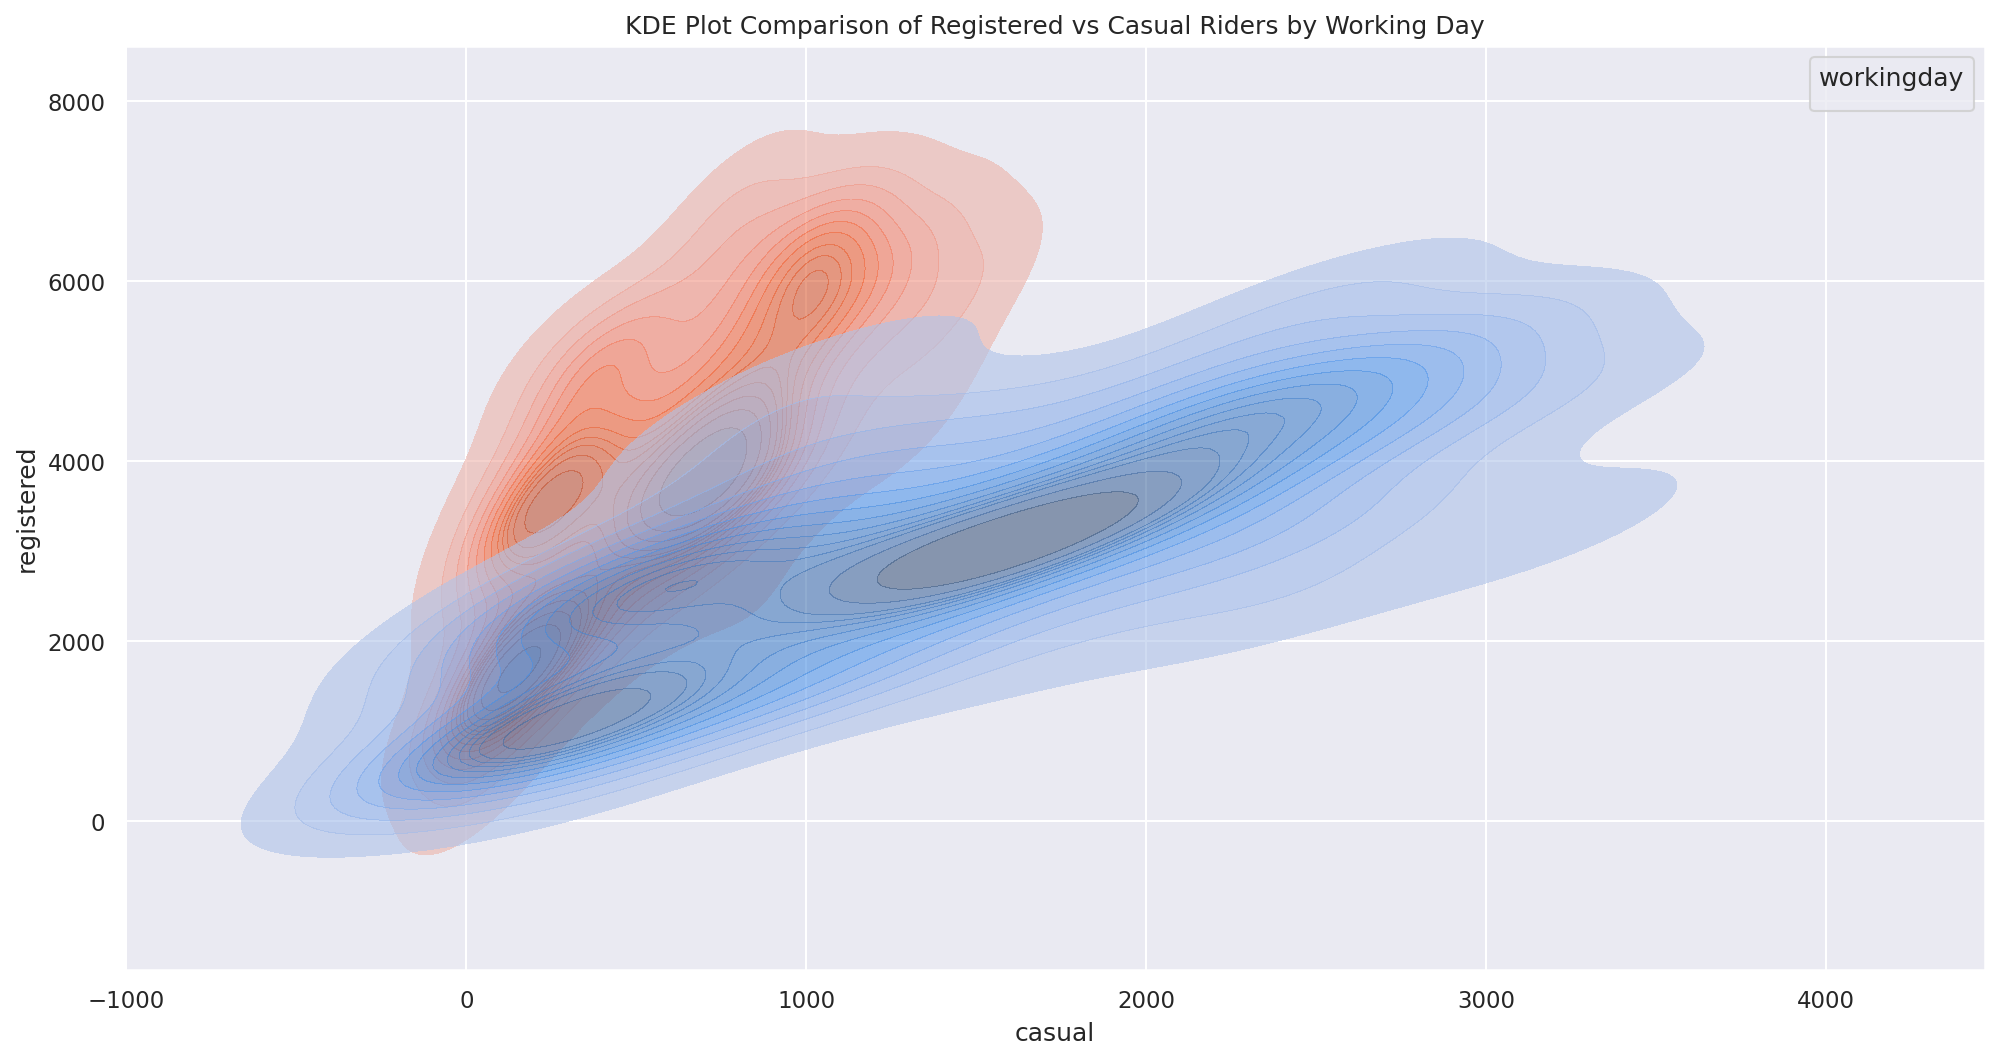

In [24]:
# bivariate kernel density estimate
sns.kdeplot(
    data=daily_counts,
    x='casual', y='registered',
    hue='workingday',
    hue_order=['yes','no'],
    palette={'yes': '#F46D43',
             'no' : '#4A90E2'},
    fill=True, levels=15, common_norm=False, thresh=0.03, alpha=0.6
)

plt.title('KDE Plot Comparison of Registered vs Casual Riders by Working Day')
plt.xlabel('casual'); plt.ylabel('registered')
plt.legend(title='workingday')
plt.show()

In [30]:
# Daily and Monthly Patterns

def hour_to_category(hour):
    if 2 <= hour < 5:
        return "Midnight"
    elif 5 <= hour < 11:
        return "Morning"
    elif 11 <= hour < 14:
        return "Lunch Time"
    elif 14 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

bike["time_category"] = bike["hr"].apply(hour_to_category)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_category
0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0,3,13,16,Night
1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,8,32,40,Night
2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,5,27,32,Midnight
3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,3,10,13,Midnight
4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,0,1,1,Midnight


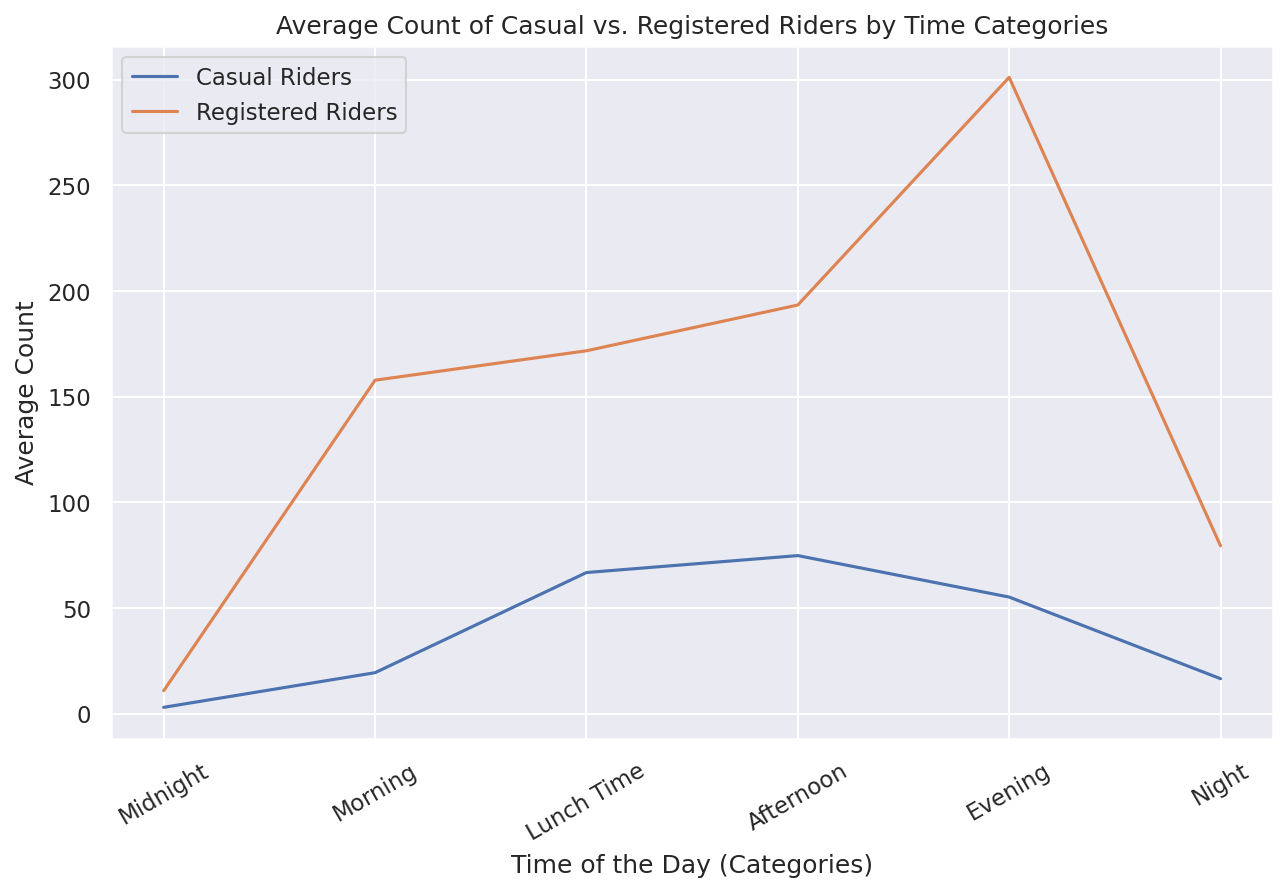

In [31]:
# Plot Average Count of Casual vs. Registered Riders by Time Categories

# Calculate average number of riders per time category
avg_riders = bike.groupby("time_category")[["casual", "registered"]].mean().reset_index()

# Set order of categories for consistent x-axis
category_order = ["Midnight", "Morning", "Lunch Time", "Afternoon", "Evening", "Night"]
avg_riders["time_category"] = pd.Categorical(avg_riders["time_category"], categories=category_order, ordered=True)
avg_riders = avg_riders.sort_values("time_category")

# Plot the line graph
plt.figure(figsize=(10,6))
plt.plot(avg_riders["time_category"], avg_riders["casual"], label="Casual Riders")
plt.plot(avg_riders["time_category"], avg_riders["registered"], label="Registered Riders")

# Add labels and title
plt.xlabel("Time of the Day (Categories)")
plt.ylabel("Average Count")
plt.title("Average Count of Casual vs. Registered Riders by Time Categories")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=30)
plt.show()

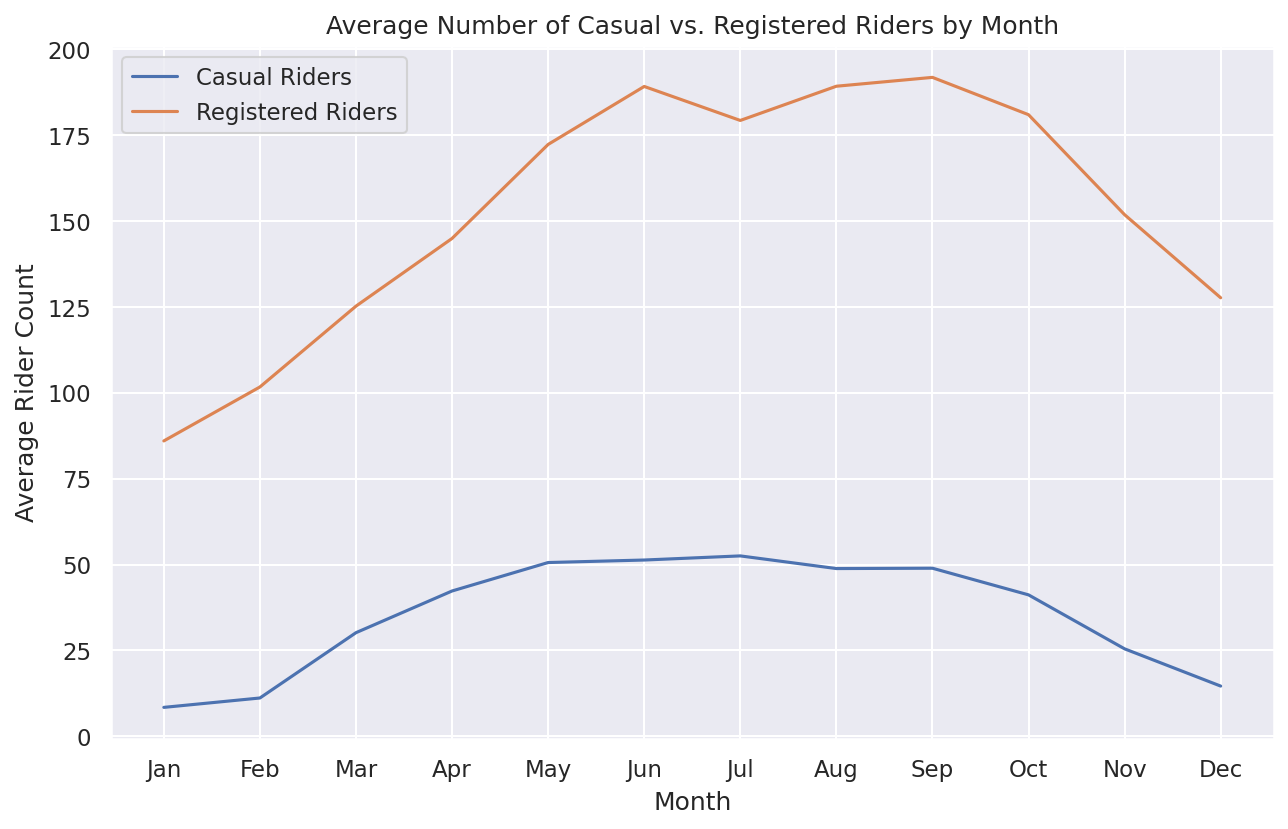

In [32]:
# Plot Average count of casual and registered riders varies by month
# Compute the average number of riders per month
avg_month = bike.groupby("mnth")[["casual", "registered"]].mean().reset_index()

# Optional: create month labels for the x-axis
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plot the lines
plt.figure(figsize=(10,6))
plt.plot(avg_month["mnth"], avg_month["casual"], label="Casual Riders")
plt.plot(avg_month["mnth"], avg_month["registered"], label="Registered Riders")

# Add labels, title, and legend
plt.title("Average Number of Casual vs. Registered Riders by Month")
plt.xlabel("Month")
plt.ylabel("Average Rider Count")
plt.legend()

# Set custom x-axis tick labels
plt.xticks(ticks=range(1,13), labels=month_labels)
plt.show()

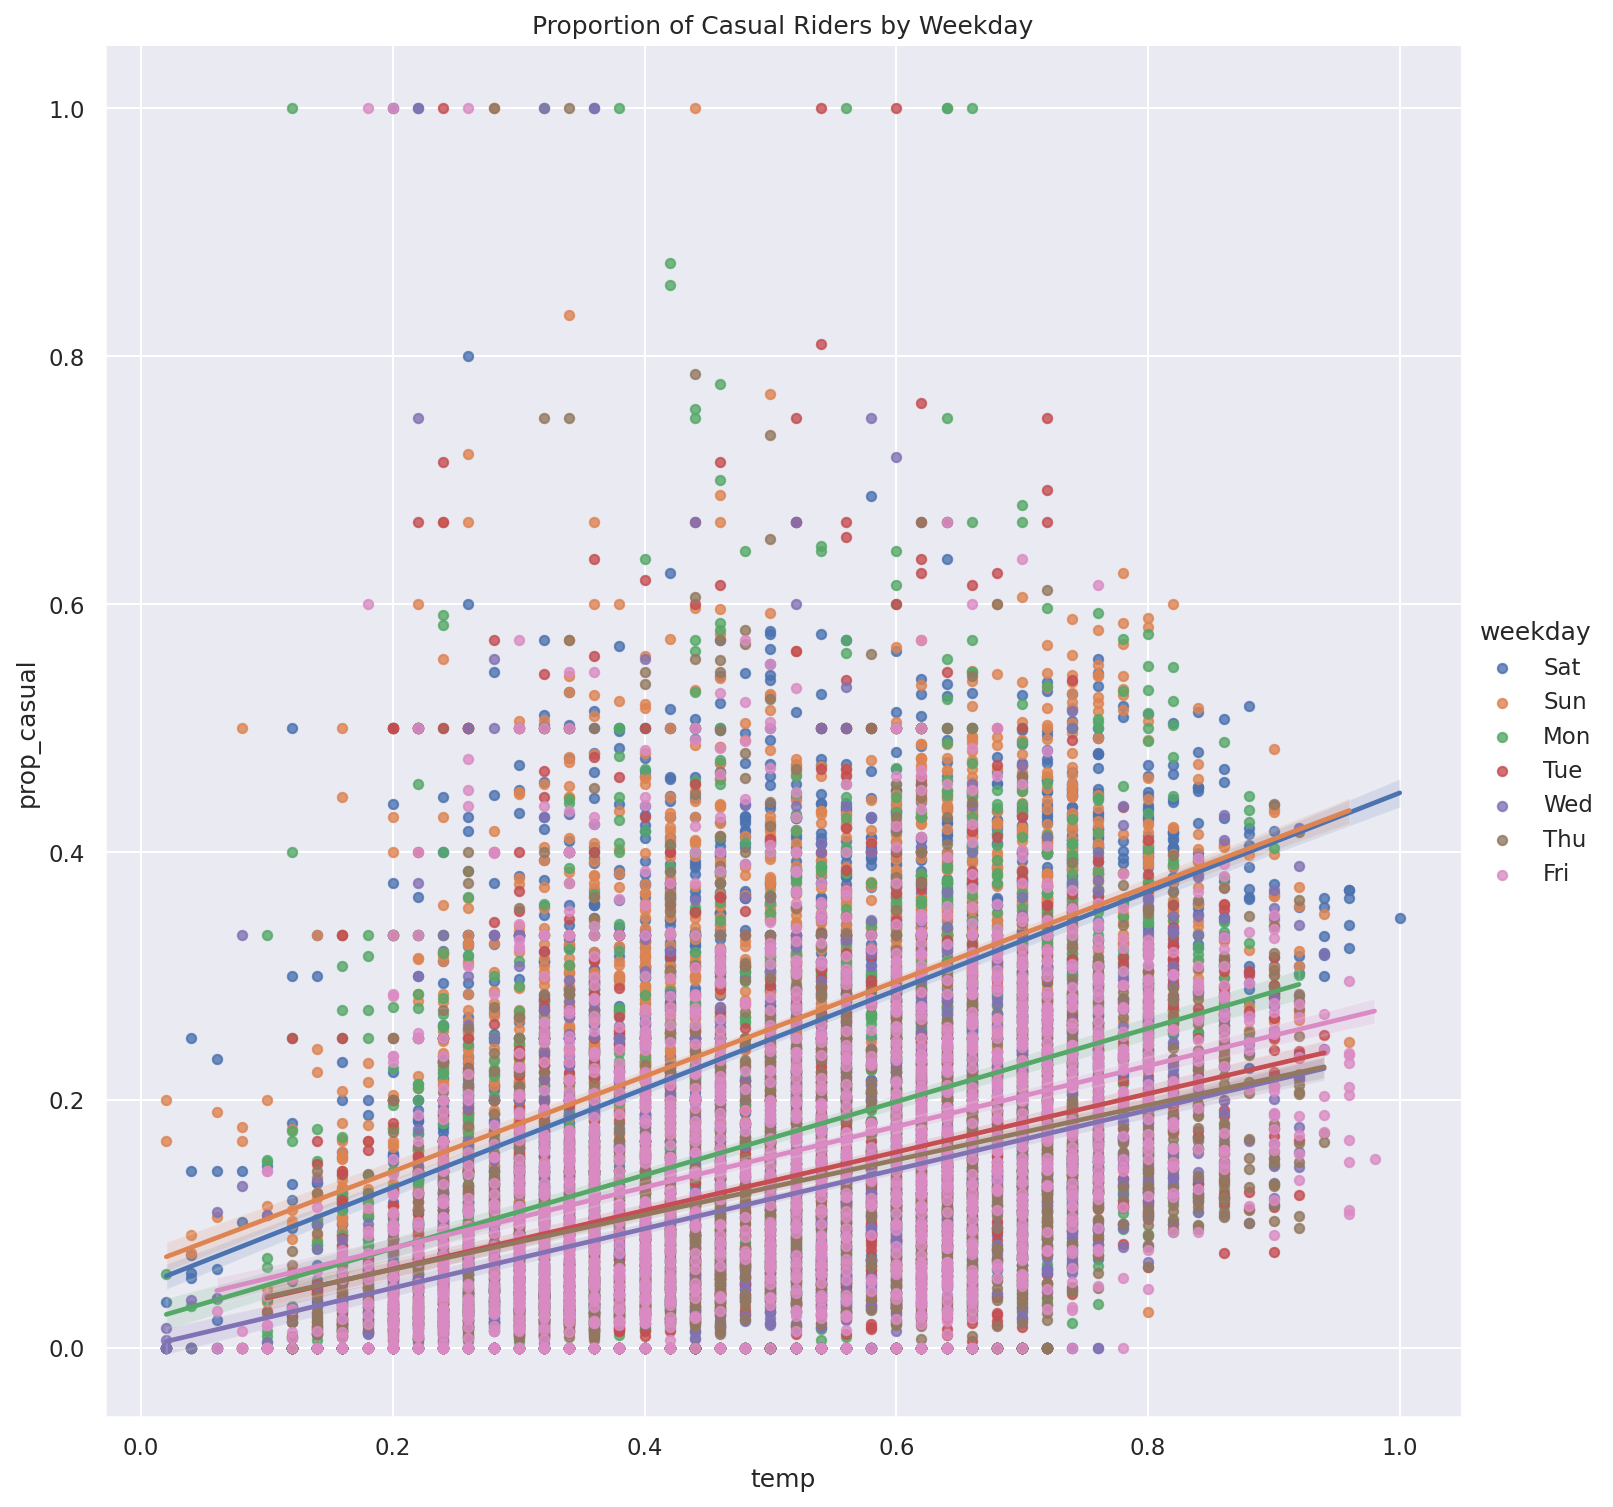

In [35]:
# Exploring Ride-Sharing and Weather
# Create a new column representing the proportion of casual riders
bike["prop_casual"] = bike["casual"] / bike["cnt"]

sns.lmplot(data=bike, x='temp', y='prop_casual', hue='weekday', scatter_kws={"s": 20}, height=10)
plt.title("Proportion of Casual Riders by Weekday");

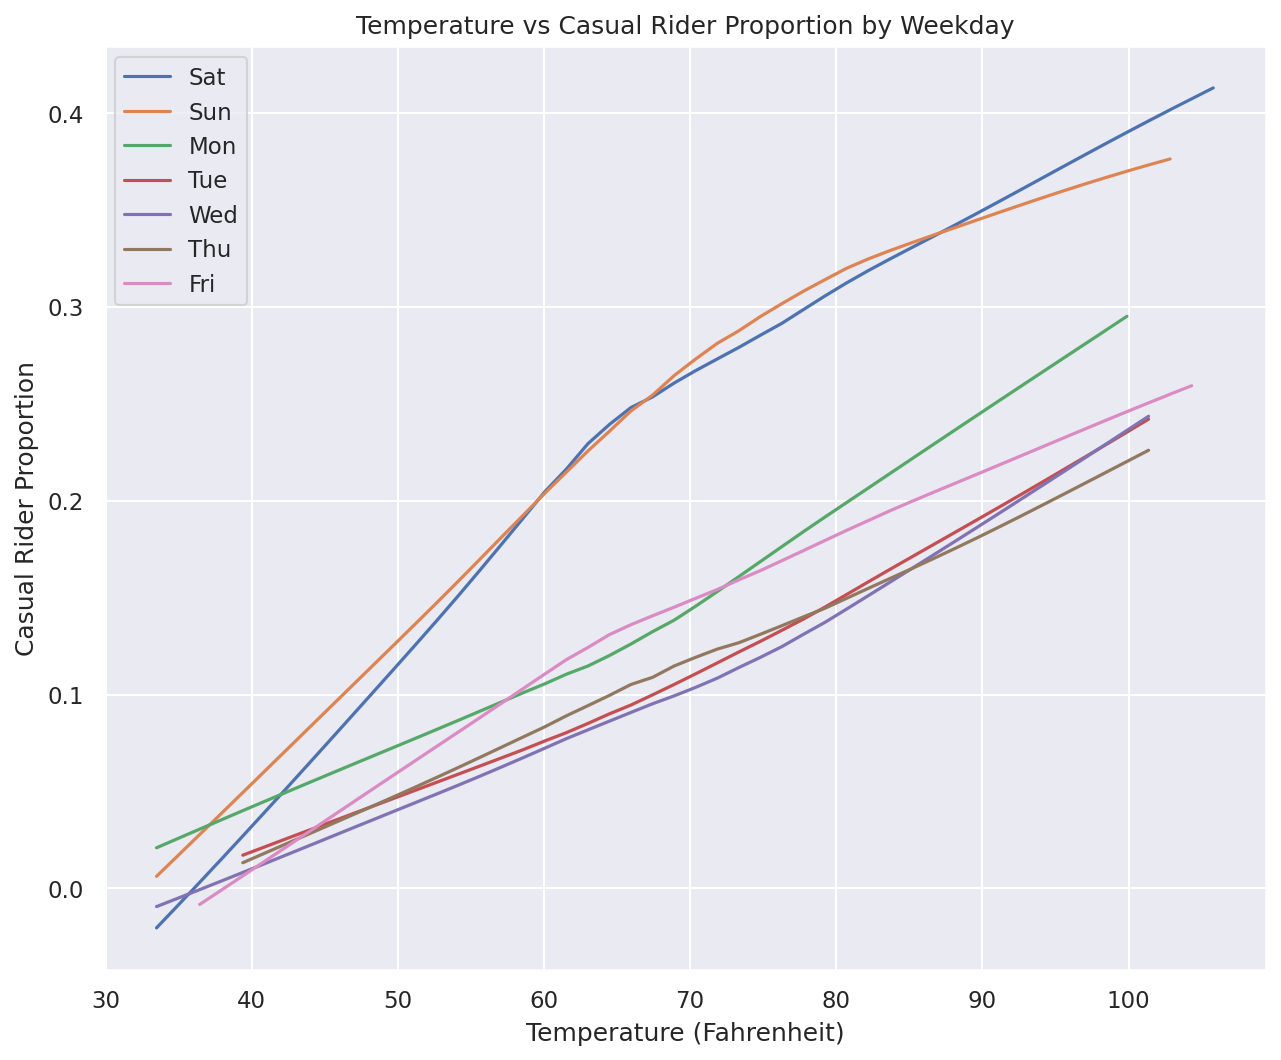

In [36]:
# Locally Weighted Scatter plot Smoothing"

from statsmodels.nonparametric.smoothers_lowess import lowess
plt.figure(figsize=(10,8))

for day in bike['weekday'].unique():
    this_day = bike[bike['weekday'] == day].copy()
    this_day['temp'] = this_day['temp'] * 41 * 9 / 5 + 32
    ysmooth = lowess(this_day['prop_casual'], this_day['temp'], return_sorted=False)
    sns.lineplot(x=this_day['temp'], y=ysmooth, label=day)

plt.title("Temperature vs Casual Rider Proportion by Weekday")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Casual Rider Proportion")
plt.legend();